Set Up Colab Environment

In [1]:
!pip install --upgrade openai
!pip install pandas numpy matplotlib seaborn scikit-learn nltk spacy wordcloud
!pip install transformers

# Download NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Download spaCy English model
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.3
    Uninstalling openai-1.59.3:
      Successfully uninstalled openai-1.59.3


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


 Imports & Drive Mount

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import spacy
import nltk
from tqdm import tqdm

# For generating policy text
import openai

# For optional sentiment or other tasks
from transformers import pipeline

# For text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud

sns.set(style='whitegrid', palette='muted', color_codes=True)

# Initialize spaCy (disable unneeded components for speed)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Data Loading

In [ ]:

def load_and_filter_data(file_list, max_rows=None, chunk_size=5_000_000):
    """
    - Reads each .csv.gz file in chunks.
    - Keeps only text, lang, replyCount, retweetCount, likeCount, quoteCount.
    - Converts engagement columns to numeric, fills NaN with 0.
    - Retains only rows where lang=='en' and any engagement >= 5.
    - Returns one DataFrame of all filtered rows (up to max_rows).

    'chunk_size' controls how many rows are read at once (for memory efficiency).
    """
    # We only care about these columns:
    data_cols = ["text", "lang", "replyCount", "retweetCount", "likeCount", "quoteCount"]

    df_list = []
    loaded_rows = 0

    for file_path in tqdm(file_list, desc="Processing files"):
        try:
            # Read in 'chunk_size' increments
            for chunk in pd.read_csv(file_path,
                                     compression='gzip',
                                     low_memory=False,
                                     usecols=data_cols,   # read only needed columns
                                     chunksize=chunk_size):
                # Ensure the columns exist
                chunk = chunk.reindex(columns=data_cols)

                # Convert engagement columns to numeric
                for col in ["replyCount", "retweetCount", "likeCount", "quoteCount"]:
                    chunk[col] = pd.to_numeric(chunk[col], errors='coerce').fillna(0)

                # Filter to English tweets
                chunk = chunk[chunk['lang'] == 'en']

                # Filter to engagement >=5
                chunk = chunk[
                    (chunk["replyCount"] >= 5) |
                    (chunk["retweetCount"] >= 5) |
                    (chunk["likeCount"] >= 5) |
                    (chunk["quoteCount"] >= 5)
                ]

                # Append the filtered chunk to list
                df_list.append(chunk)
                loaded_rows += len(chunk)

                # Stop if we have reached max_rows (optional)
                if max_rows and loaded_rows >= max_rows:
                    break
            # If we've reached max_rows, stop reading further files
            if max_rows and loaded_rows >= max_rows:
                break
        except Exception as e:
            print("Error loading file:", file_path, e)

    # Concatenate all filtered chunks
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        # If no data was loaded at all, return an empty DataFrame
        return pd.DataFrame(columns=data_cols)


# 1) Define path to your base directory (containing part_1, part_2, etc.)
DATA_PATH = '/content/drive/MyDrive/Emillio/usc-x-24-us-election'

# 2) Recursively gather all .csv.gz in subfolders
csv_files = glob.glob(os.path.join(DATA_PATH, '**', '*.csv.gz'), recursive=True)
print("Number of files found:", len(csv_files))

# 3) Load up to e.g. 500k final rows (adjust as desired)
df_filtered = load_and_filter_data(csv_files)

print(f"Total rows after filtering: {len(df_filtered)}")
df_filtered.info()
df_filtered.head()

Number of files found: 697


Processing files:   0%|          | 1/697 [00:00<05:10,  2.24it/s]

Error loading file: /content/drive/MyDrive/Emillio/usc-x-24-us-election/part_6/may_july_chunk_101.csv.gz Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


Processing files:   0%|          | 2/697 [00:02<15:58,  1.38s/it]


KeyboardInterrupt: 

In [ ]:
# CSVファイルとして保存
df_filtered.to_csv('filtered_data.csv', index=False)

In [10]:
df_filtered=pd.read_csv("/content/drive/MyDrive/Emillio/filtered_data.csv")

Text Preprocessing

In [ ]:
# Standard English stopwords
nltk_stop = set(stopwords.words("english"))

# Optional: add candidate or party names to the stop list
extra_stopwords = {
    "biden","trump","kamala","desantis","rfk","kennedy","gop",
    "democrat","republican","rnc","dnc","donald","joe","rnc","obama","maga", "conservative", "win", "lose", "harris", "drop", "assassination", "shoot", "party"
}
nltk_stop = nltk_stop.union(extra_stopwords)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # remove URLs
    text = re.sub(r'\@\w+', '', text)                    # remove @mentions
    text = re.sub(r'\d+', '', text)                      # remove digits
    text = re.sub(r'[^\w\s]', '', text)                  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_filtered['clean_text'] = df_filtered['text'].astype(str).apply(clean_text)

# Filter out short texts
df_filtered = df_filtered[df_filtered['clean_text'].str.len() > 20]
print(f"After cleaning & length filter: {len(df_filtered)}")
df_filtered[['text','clean_text']].head()


After cleaning & length filter: 3034700


,text,clean_text
0,The Biden-Harris admin is leakier than a sinki...,the bidenharris admin is leakier than a sinkin...
1,Before you start screaming liberal blah blah b...,before you start screaming liberal blah blah b...
2,So easily verifiable. \n\nThese little people ...,so easily verifiable these little people are c...
3,President Obama’s entire administration spent ...,president obamas entire administration spent a...
4,Eminem is expected to introduce Barack Hussein...,eminem is expected to introduce barack hussein...


Lemmatization with spaCy’s nlp.pipe

In [ ]:
docs_list = df_filtered['clean_text'].tolist()

lemmatized_texts = []
batch_size = 32
n_process = 2  # if you have multi-core CPU, you can set >1

docs = nlp.pipe(docs_list, batch_size=batch_size, n_process=n_process)

for doc in tqdm(docs):
    lemmas = [token.lemma_ for token in doc if token.lemma_ != '-PRON-' and token.lemma_ not in nltk_stop]
    lemmatized_texts.append(" ".join(lemmas))

df_filtered['clean_text'] = lemmatized_texts
df_filtered[['clean_text']].head()


3034700it [49:29, 1021.93it/s]


,clean_text
0,bidenharris admin leaky sink ship entire milit...
1,start scream liberal blah blah blah american e...
2,easily verifiable little people consistently m...
3,president obamas entire administration spend d...
4,eminem expect introduce barack hussein rally d...


In [ ]:
df_filtered

,text,lang,replyCount,retweetCount,likeCount,quoteCount,clean_text
0,The Biden-Harris admin is leakier than a sinki...,en,5.0,4.0,29.0,0.0,bidenharris admin leaky sink ship entire milit...
1,Before you start screaming liberal blah blah b...,en,0.0,4.0,13.0,0.0,start scream liberal blah blah blah american e...
2,So easily verifiable. \n\nThese little people ...,en,1.0,3.0,16.0,0.0,easily verifiable little people consistently m...
3,President Obama’s entire administration spent ...,en,0.0,9.0,17.0,0.0,president obamas entire administration spend d...
4,Eminem is expected to introduce Barack Hussein...,en,23.0,11.0,126.0,4.0,eminem expect introduce barack hussein rally d...
...,...,...,...,...,...,...,...
3138213,This. 👇 Health care saves lives. That's why @i...,en,12.0,27.0,77.0,2.0,health care save live advocate medicaid expans...
3138214,@Yppop379342 @enslaved1s @adxl888 @plies The f...,en,1.0,0.0,7.0,0.0,first day president sign eo pause construction...
3138215,Live blogging Omar's Dem primary has the be th...,en,0.0,0.0,11.0,0.0,live blogge omar dem primary sorriest waste ti...
3138216,You might want to watch and retweet this video...,en,0.0,5.0,4.0,0.0,might want watch retweet video trigger


In [ ]:
# Save data as a CSV file
df_filtered.to_csv('df_filtered_harris.csv', index=False)
print("Topics saved as 'topics.csv'")


Topics saved as 'topics.csv'


In [11]:
df_filtered=pd.read_csv("/content/drive/MyDrive/Emillio/df_filtered_harris.csv")

In [12]:
df_filtered

# Remove rows with NaN values
df_filtered = df_filtered.dropna(subset=['clean_text'])

Topic Modeling with TF-IDF + LDA

In [5]:
vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=10,
    stop_words='english'
)
dtm = vectorizer.fit_transform(df_filtered['clean_text'])
print("DTM shape:", dtm.shape)

n_topics = 10  # Adjust as needed
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch'
)
lda_model.fit(dtm)

def display_topics(model, feature_names, top_words=10):
    topic_map = {}
    for idx, comp in tqdm(enumerate(model.components_)):
        top_features_idx = comp.argsort()[:-top_words-1:-1]
        top_terms = [feature_names[i] for i in top_features_idx]
        topic_map[idx] = top_terms
        print(f"Topic {idx+1}: {', '.join(top_terms)}")
    return topic_map

feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda_model, feature_names)


DTM shape: (3032385, 46185)


10it [00:00, 209.54it/s]

Topic 1: president, poll, vote, voter, election, new, state, democratic, candidate, convention
Topic 2: medium, like, lie, people, say, make, know, think, post, right
Topic 3: people, like, amp, president, say, christian, vote, think, man, good
Topic 4: israel, war, ukraine, president, administration, support, say, gaza, russia, genocide
Topic 5: president, attempt, covid, say, press, bad, conference, putin, debate, know
Topic 6: border, illegal, inflation, tax, year, pay, bidenharris, administration, money, price
Topic 7: debate, say, president, news, rt, interview, watch, like, time, house
Topic 8: thank, follow, good, patriot, america, great, day, let, president, fuck
Topic 9: vote, election, court, president, hunter, rt, ballot, supreme, democracy, say
Topic 10: vote, say, like, people, think, know, woman, want, man, black


Dominant Topic Assignment & Visualization

<ipython-input-6-48100ce725c8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index+1, y=topic_counts.values, palette='viridis')


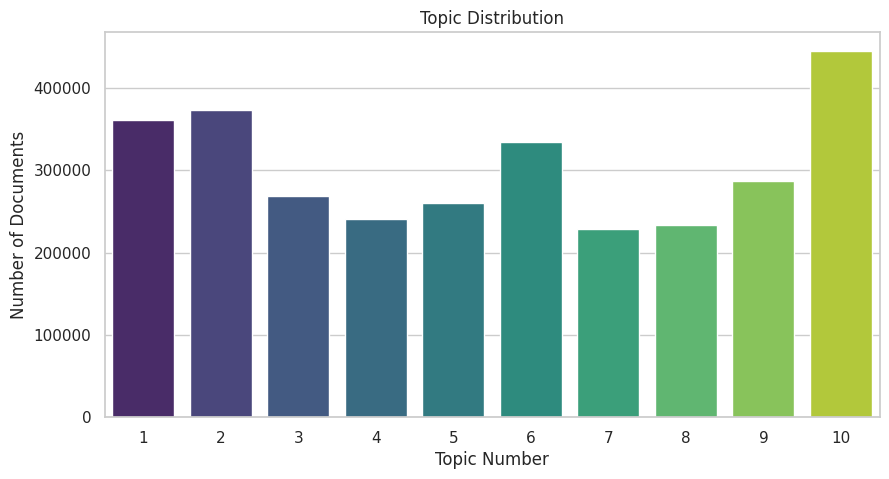

In [6]:
doc_topic_matrix = lda_model.transform(dtm)
df_filtered['topic_id'] = doc_topic_matrix.argmax(axis=1)

topic_counts = df_filtered['topic_id'].value_counts().sort_index()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(x=topic_counts.index+1, y=topic_counts.values, palette='viridis')
plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.title("Topic Distribution")
plt.show()


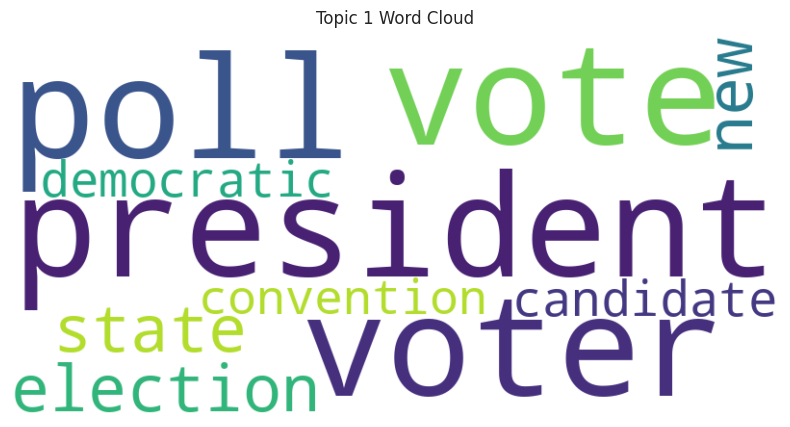

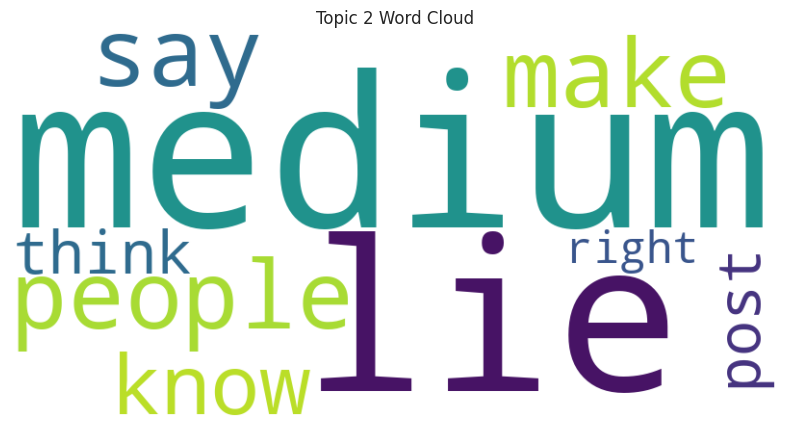

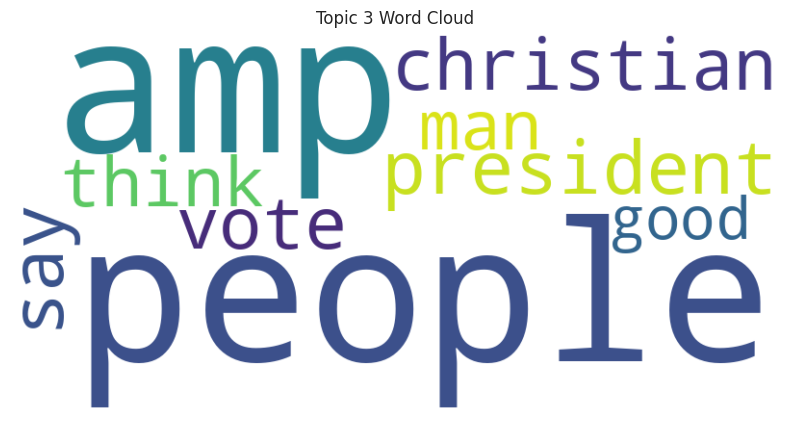

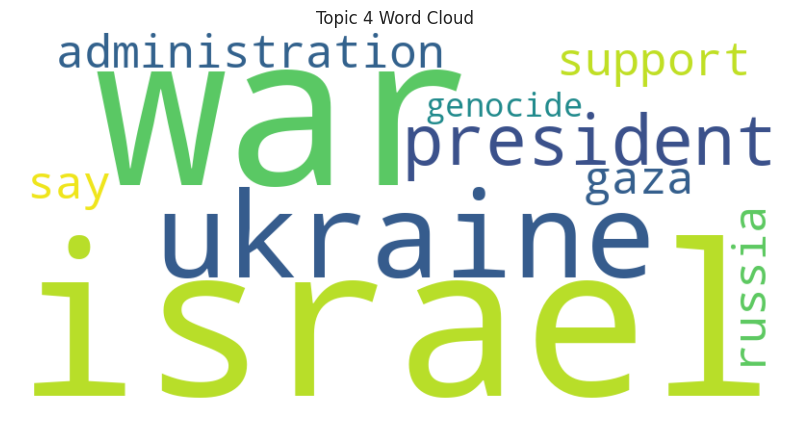

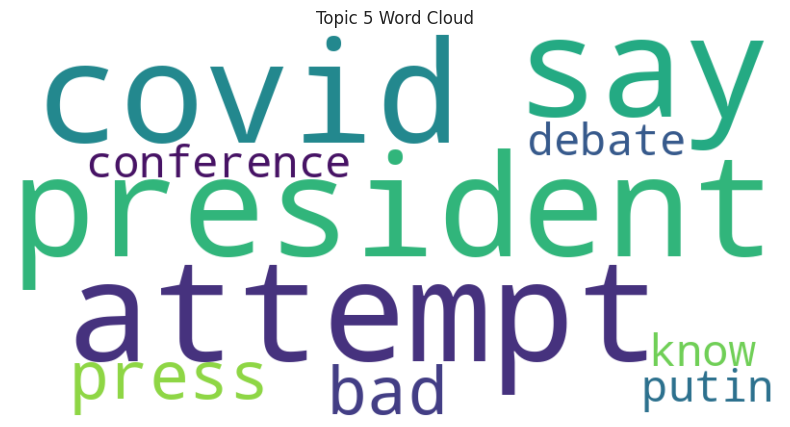

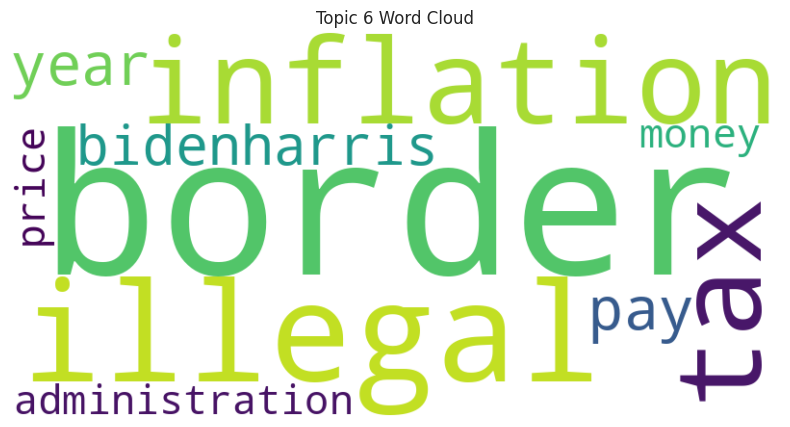

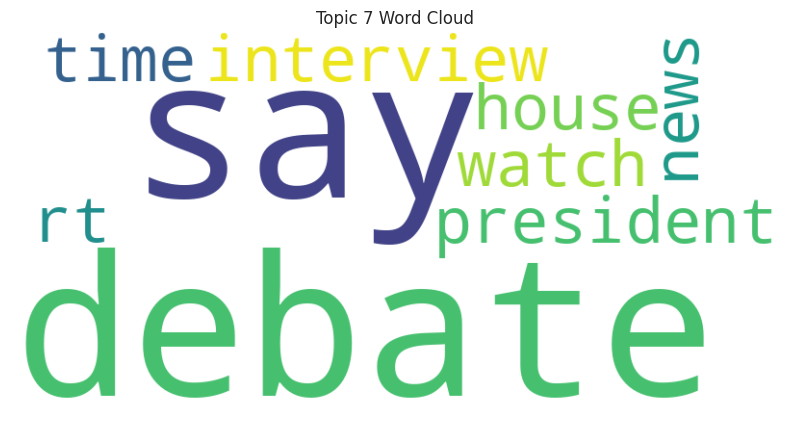

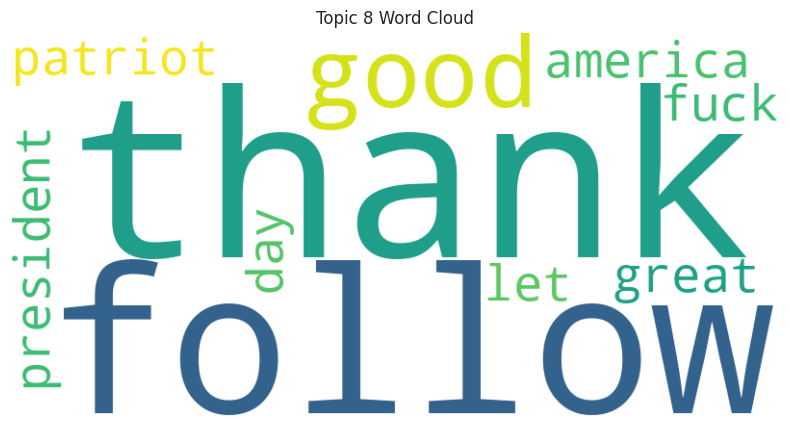

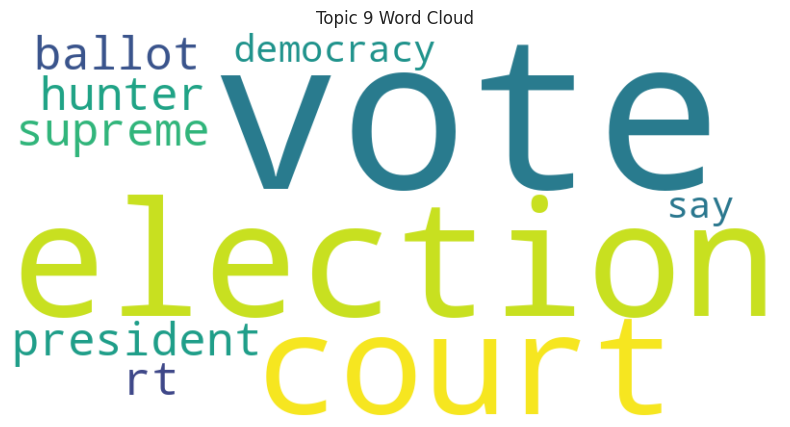

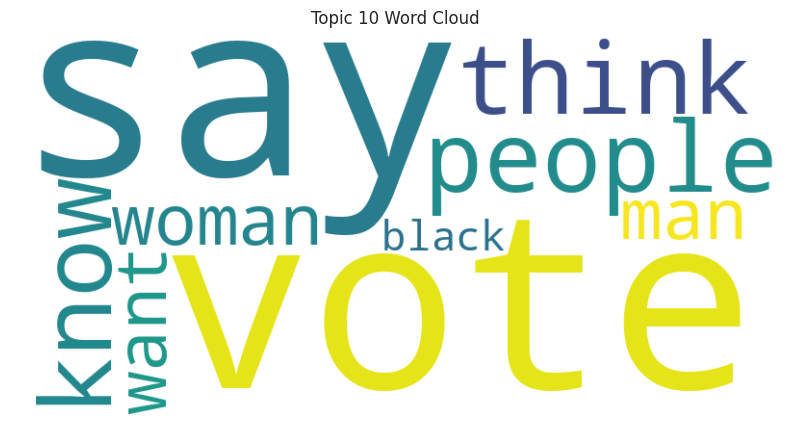

In [7]:
# Word Clouds for each topic
from wordcloud import WordCloud

for t_id, kws in topics.items():
    text_wc = " ".join(kws)
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_wc)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Topic {t_id+1} Word Cloud")
    plt.show()


In [8]:
for idx, _ in enumerate(topics.items()):
  print(f"Topic {idx+1}: {', '.join(topics[idx])}")

Topic 1: president, poll, vote, voter, election, new, state, democratic, candidate, convention
Topic 2: medium, like, lie, people, say, make, know, think, post, right
Topic 3: people, like, amp, president, say, christian, vote, think, man, good
Topic 4: israel, war, ukraine, president, administration, support, say, gaza, russia, genocide
Topic 5: president, attempt, covid, say, press, bad, conference, putin, debate, know
Topic 6: border, illegal, inflation, tax, year, pay, bidenharris, administration, money, price
Topic 7: debate, say, president, news, rt, interview, watch, like, time, house
Topic 8: thank, follow, good, patriot, america, great, day, let, president, fuck
Topic 9: vote, election, court, president, hunter, rt, ballot, supreme, democracy, say
Topic 10: vote, say, like, people, think, know, woman, want, man, black


In [9]:
# Convert topic_map (topics) to a DataFrame
topics_df = pd.DataFrame.from_dict(topics, orient='index').transpose()

# Save topics as a CSV file
topics_df.to_csv('topics_harris.csv', index=False)
print("Topics saved as 'topics.csv'")

Topics saved as 'topics.csv'


Policy Generation Using ChatGPT

In [ ]:

# You are a policy maker. You will receive a prompt describing a hot topic and you should extract topics which support citizens.

# 1. Summarize the key public concerns related to this topic.
# 2. Picking up three topics which is more important but not addressed.
# 3. Propose actionable policy measures to address these three topics.
# 4. Ensure that the each proposed policies are feasible, inclusive, and enhance democratic governance .

# ["INPUT_TOPIC"]


In [ ]:
Could you search the background of the below keywords?

# keyword
["INPUT_KEYWORD"]  # israel, war, administration, ukraine, harris, policy, president, inflation, say, amp

In [ ]:

**Role Definition:**
You are a seasoned policy advisor in the U.S. with extensive experience in democratic governance, international relations, and economic policy formulation. Your expertise lies in creating comprehensive, feasible, and inclusive policy measures that address complex societal challenges.

---

### **Topic Summary:**
- **Keywords:** israel, war, administration, ukraine, harris, policy, president, inflation, say, amp

---

### **Additional Context:**


---
### **Tasks:**

1. **Summarize the Key Public Concerns:**
   - Provide a detailed summary of the main public concerns related to this topic, incorporating the provided keywords, sample texts, and sentiment analysis.

2. **Identify Three Unaddressed but Important Areas:**
   - Highlight three specific areas within this topic that are currently not being addressed but are crucial for maintaining democratic governance and societal well-being.

3. **Propose Actionable Policy Measures:**
   - For each of the three identified areas, suggest comprehensive policy measures that are:
     - **Feasible:** Can be realistically implemented within the current political and economic framework.
     - **Inclusive:** Consider the diverse needs and perspectives of all affected populations.
     - **Enhancing Democratic Governance:** Strengthen democratic institutions, transparency, and public trust.

4. **Provide Implementation Strategies:**
   - For each proposed policy, outline brief implementation strategies, including key steps, responsible agencies, and potential challenges with mitigation approaches.

---

**Format your response clearly with headings and subheadings for each section. Use bullet points or numbered lists where appropriate to enhance readability and structure.**
